In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('quora_duplicate_questions.tsv', sep='\t',nrows=50000)
df.shape

(50000, 6)

In [3]:
df.head(6)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1


In [4]:
# extract single row
df.iloc[5]['question1']

'Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?'

In [5]:
#check null value
df[df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate


In [6]:
df = df.fillna('')

In [7]:
df[df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate


In [8]:
df.is_duplicate.value_counts(1)*100

0    62.702
1    37.298
Name: is_duplicate, dtype: float64

### Split Data In To train-test

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df['is_duplicate'], stratify = df['is_duplicate'], random_state = 5)

In [10]:
# Printing shape of train and test data
print("Shape of Train data : ", X_train.shape, y_train.shape)
print("Shape of Test data : ", X_test.shape, y_test.shape)

Shape of Train data :  (37500, 6) (37500,)
Shape of Test data :  (12500, 6) (12500,)


In [11]:
# Removing target feature from train and test data
X_train = X_train.drop((['is_duplicate','id','qid1','qid2']), axis=1)
X_test = X_test.drop((['is_duplicate','id','qid1','qid2']), axis=1)

In [12]:
X_train.head()

,question1,question2
46084,What are some good psychological hacks?,What are some interesting psychological hacks?
31337,Does long distance relationships actually work?,How will long distance relationship work?
20200,"What's difference between stock, stable and ni...",Which custom ROM is stable for a Moto G Falcon...
498,Is growing of hair a physical or a chemical ch...,Can a bald person ever grow their hair back?
39170,How can I make rs 10000 per month with 1 lakh ...,How can I invest Rs. 1 lakh to get 10000 monthly?


In [13]:
X_test.head()

,question1,question2
28593,How do I improve the habit of waking up early ...,How can I make waking up earlier a habit?
38151,What are the easy ways to earn money online?,What are the various ways through which one ca...
12237,Does anyone still use Google+?,Does anyone actually use Google +?
17619,Has Lennon or McCartney ever said anything abo...,What made the Lennon-McCartney partnership so ...
29590,What is the best business to start in a villag...,What is a best business to start in one to thr...


## Applying Tf-Idf Vectorizer on the Text data

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
# Before fitting Tf-Idf Vectorizer we need to combine both question1 and question 2
Combined_que = list(X_train['question1']) + list(X_train['question2'])

In [15]:
vectorizer.fit(Combined_que)

TfidfVectorizer()

In [16]:
#dump tfidf
import pickle
pickle.dump(vectorizer, open('tfidf-transform.pkl', 'wb'))

In [17]:
# Applying Tf-Idf Vectorizer on Question-1
train_tfidf_q1 = vectorizer.transform(X_train['question1'])
test_tfidf_q1 = vectorizer.transform(X_test['question1'])

In [18]:
# Applying Tf-Idf Vectorizer on Question-2
train_tfidf_q2 = vectorizer.transform(X_train['question2'])
test_tfidf_q2 = vectorizer.transform(X_test['question2'])

In [19]:
# Extracting Features
X_train_features = X_train.drop(['question1','question2'], axis = 1, inplace = False)
X_test_features = X_test.drop(['question1','question2'], axis = 1, inplace = False)

In [20]:
# Printing Shape of text Train and test data after Vectorizing
print("Shape of Train Question-1 matrix after Vectorizing : ", train_tfidf_q1.shape)
print("Shape of Train Question-2 matrix after Vectorizing : ", train_tfidf_q2.shape)
print("Shape of Test Question-1 matrix after Vectorizing : ", test_tfidf_q1.shape)
print("Shape of Test Question-2 matrix after Vectorizing : ", test_tfidf_q2.shape)

Shape of Train Question-1 matrix after Vectorizing :  (37500, 29070)
Shape of Train Question-2 matrix after Vectorizing :  (37500, 29070)
Shape of Test Question-1 matrix after Vectorizing :  (12500, 29070)
Shape of Test Question-2 matrix after Vectorizing :  (12500, 29070)


## Merging All the Features

In [21]:
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

In [22]:
X_train_s1 = hstack((csr_matrix(X_train_features), train_tfidf_q1, train_tfidf_q2))
X_test_s1 = hstack((csr_matrix(X_test_features), test_tfidf_q1, test_tfidf_q2))

# Printing Shape of both Train and Test data after merging Features
print("Shape of Training Data : ", X_train_s1.shape, y_train.shape)
print("Shape of Test Data : ", X_test_s1.shape, y_test.shape)

Shape of Training Data :  (37500, 58140) (37500,)
Shape of Test Data :  (12500, 58140) (12500,)


In [23]:
from imblearn.over_sampling import SMOTE
X_train_s1 , y_train = SMOTE().fit_sample(X_train_s1, y_train)
X_test_s1 , y_test = SMOTE().fit_sample(X_test_s1 , y_test)

In [24]:
X_train_s1.shape,X_test_s1.shape,y_train.shape,y_test.shape

((47026, 58140), (15676, 58140), (47026,), (15676,))

## Model Build

In [25]:
from sklearn.metrics import log_loss,confusion_matrix
from sklearn.metrics import accuracy_score,classification_report
import warnings
warnings.simplefilter('ignore')

In [26]:
def plot_confusion_matrix(t_y, p_y):
    C = confusion_matrix(t_y, p_y)
    A = (((C.T) / (C.sum(axis=1))).T)
    B = (C/C.sum(axis=0))
    
    
    plt.figure(figsize=(20,4))
    labels = [1,2]
    
    
    cmap=sns.light_palette("green")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    plt.show()

## Logisic Regression

In [27]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='lbfgs',C=1)
clf.fit(X_train_s1, y_train)

LogisticRegression(C=1)

In [28]:
y_pred = clf.predict(X_test_s1)
print("Log loss - ",log_loss(y_test,y_pred))
print("Accuracy is - ",accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Log loss -  9.635089842421843
Accuracy is -  0.7210385302373055
              precision    recall  f1-score   support

           0       0.71      0.74      0.73      7838
           1       0.73      0.70      0.71      7838

    accuracy                           0.72     15676
   macro avg       0.72      0.72      0.72     15676
weighted avg       0.72      0.72      0.72     15676



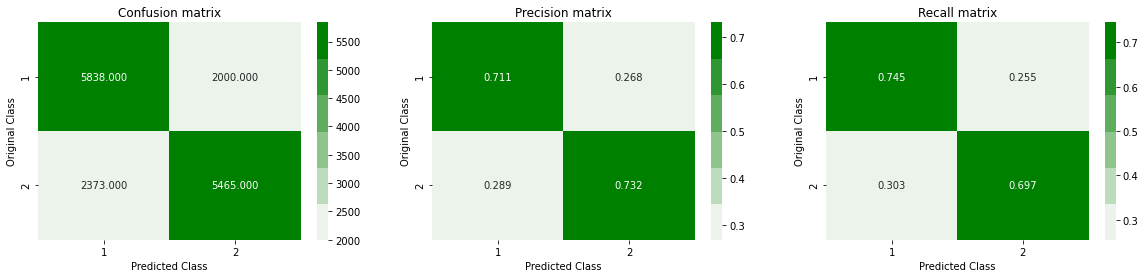

In [29]:
plot_confusion_matrix(y_test,y_pred)

## LGBM

In [30]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier().fit(X_train_s1, y_train)

In [31]:
y_pred = lgb.predict(X_test_s1)
print("Log loss - ",log_loss(y_test,y_pred))
print("Accuracy is - ",accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Log loss -  7.870235610234091
Accuracy is -  0.7721357489155397
              precision    recall  f1-score   support

           0       0.76      0.79      0.78      7838
           1       0.78      0.75      0.77      7838

    accuracy                           0.77     15676
   macro avg       0.77      0.77      0.77     15676
weighted avg       0.77      0.77      0.77     15676



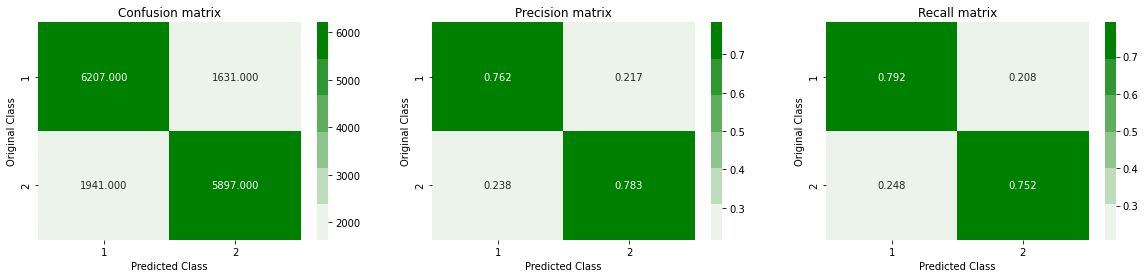

In [32]:
plot_confusion_matrix(y_test,y_pred)

In [33]:
from xgboost import XGBClassifier
xgb = XGBClassifier().fit(X_train_s1, y_train)

[22:32:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [34]:
y_pred = xgb.predict(X_test_s1)
print("Log loss - ",log_loss(y_test,y_pred))
print("Accuracy is - ",accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Log loss -  7.894454612276069
Accuracy is -  0.7714340392957387
              precision    recall  f1-score   support

           0       0.74      0.83      0.79      7838
           1       0.81      0.71      0.76      7838

    accuracy                           0.77     15676
   macro avg       0.78      0.77      0.77     15676
weighted avg       0.78      0.77      0.77     15676



In [35]:
import pickle
filename = 'quora_sim.pkl'
pickle.dump(xgb, open(filename, 'wb'))

## prettytable

In [36]:
from prettytable import PrettyTable
pt = PrettyTable()
pt.field_names = ['No.', 'Model Name', 'Hyperparameter Tunning', 'Test Log-Loss']

pt.add_row(["1","Logistic Regression (Tf-Idf)", "No", "9.044"])

print(pt)

+-----+------------------------------+------------------------+---------------+
| No. |          Model Name          | Hyperparameter Tunning | Test Log-Loss |
+-----+------------------------------+------------------------+---------------+
|  1  | Logistic Regression (Tf-Idf) |           No           |     9.044     |
+-----+------------------------------+------------------------+---------------+


In [37]:
# import sklearn
# sklearn.metrics.SCORERS.keys()

### User Pred

In [53]:
from scipy.sparse import hstack
q1 = " What is 2 + 3 ? "
q2 = " What is 6 / 44 ? "

In [54]:
tfidf_q1 = vectorizer.transform(['q1'])
tfidf_q2 = vectorizer.transform(['q2'])

question = hstack([tfidf_q1,tfidf_q2]).toarray()

pred = xgb.predict(question)

if pred[0] == 1:
    print('Question Are Same')
elif pred[0] == 0:
    print('Question Different')

Question Are Same


In [42]:
# extract single row
df.iloc[0]['question2']

'What is the step by step guide to invest in share market?'